In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
import hvplot.pandas
import mplfinance as mpf

In [2]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
#Getting BTC Dataframe

# Define the ticker symbol for Bitcoin
btc_symbol = "BTC-USD"

# Specify the date range for the past 10 years
start_date = "2013-10-09"
end_date = "2023-12-04"

# Use yfinance to get Bitcoin data for the specified date range
btc_data = yf.download(btc_symbol, start=start_date, end=end_date, progress=False)

ohlc_btc = btc_data.copy()

# Extract the "Close" column and create a DataFrame
btc_df = btc_data[["Close"]]

# Print the first few rows of the DataFrame
print(btc_df.head())
print(btc_df.tail())

                 Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
                   Close
Date                    
2023-11-29  37858.492188
2023-11-30  37712.746094
2023-12-01  38688.750000
2023-12-02  39476.332031
2023-12-03  39978.390625


In [4]:
# Plot the closing prices for Bitcoin
btc_df.hvplot.line(
    title="Bitcoin Closing Prices",
    xlabel="Date",
    ylabel="Closing Price ($)",
    width=1000,
    height=400,
)


:Curve   [Date]   (Close)

In [5]:
# Preprocessing Data
bitcoin_data = btc_df.copy()
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [6]:
# Show the last five rows
bitcoin_data.tail()

,Close
Date,
2023-11-29,37858.492188
2023-11-30,37712.746094
2023-12-01,38688.750000
2023-12-02,39476.332031
2023-12-03,39978.390625


In [7]:
# Generate synthetic price data
np.random.seed(42)
dates = pd.date_range(start='2013-01-01', end='2023-01-01', freq='D')
prices = 1000 + np.cumsum(np.random.normal(0, 1, len(dates)))

In [8]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Price': prices})
df.set_index('Date', inplace=True)

In [9]:
# Define a simple moving average crossover strategy
class MovingAverageStrategy(nn.Module):
    def __init__(self, short_window, long_window):
        super(MovingAverageStrategy, self).__init__()
        self.short_mavg = nn.Conv1d(1, 1, kernel_size=short_window, stride=1, padding=0)
        self.long_mavg = nn.Conv1d(1, 1, kernel_size=long_window, stride=1, padding=0)

    def forward(self, x):
        short_avg = self.short_mavg(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        long_avg = self.long_mavg(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        return short_avg, long_avg


In [10]:
# Backtest function
def backtest_strategy(data, strategy, short_window, long_window):
    signals = []
    for i in range(len(data) - max(short_window, long_window)):
        prices_window = torch.tensor(data['Price'].values[i:i+max(short_window, long_window)], dtype=torch.float32)
        short_avg, long_avg = strategy(prices_window)

        if short_avg > long_avg:
            signals.append(1)  # Buy signal
        else:
            signals.append(-1)  # Sell signal

    return signals

In [11]:
# Backtest parameters
short_window = 30
long_window = 90

In [12]:
# Create and train the strategy
strategy = MovingAverageStrategy(short_window, long_window)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(strategy.parameters(), lr=0.001)


In [13]:
# Convert the prices to PyTorch tensor
prices_tensor = torch.tensor(df['Price'].values, dtype=torch.float32)

In [14]:
# Define the backtest_strategy function
def backtest_strategy(data, strategy, short_window, long_window):
    signals = []
    for i in range(len(data) - max(short_window, long_window)):
        prices_window = torch.tensor(data['Price'].values[i:i+max(short_window, long_window)], dtype=torch.float32)
        short_avg, long_avg = strategy(prices_window)

        if short_avg[-1] > long_avg[-1]:
            signals.append(1)  # Buy signal
        else:
            signals.append(-1)  # Sell signal

    return signals

# Backtest the strategy
signals = backtest_strategy(df, strategy, short_window, long_window)



In [15]:
def calculate_sharpe_ratio(returns):
  
    return np.sqrt(252) * (np.mean(returns) / np.std(returns))

def calculate_maximum_drawdown(prices):
    cumulative_returns = np.cumsum(prices)
    max_drawdown = .1
    peak = 10

    for i in range(1, len(cumulative_returns)):
        if cumulative_returns[i] > cumulative_returns[peak]:
            peak = i
        else:
            drawdown = (cumulative_returns[peak] - cumulative_returns[i]) / cumulative_returns[peak]
            max_drawdown = max(max_drawdown, drawdown)

    return max_drawdown

# Extracting returns from signals
df['Returns'] = df['Price'].pct_change().fillna(0)
returns = df['Returns'].tolist()

# Calculating Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns)

# Calculating Maximum Drawdown
prices_list = df['Price'].values.tolist()
maximum_drawdown = calculate_maximum_drawdown(prices_list)

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", maximum_drawdown)


Sharpe Ratio: 0.41560381043432676
Maximum Drawdown: 0.8185861393863274


In [16]:
# Visualize the backtest results
df['Signal'] = [0] * max(short_window, long_window) + signals
df['Position'] = df['Signal'].diff()

In [17]:
cdt = df.tail(61)

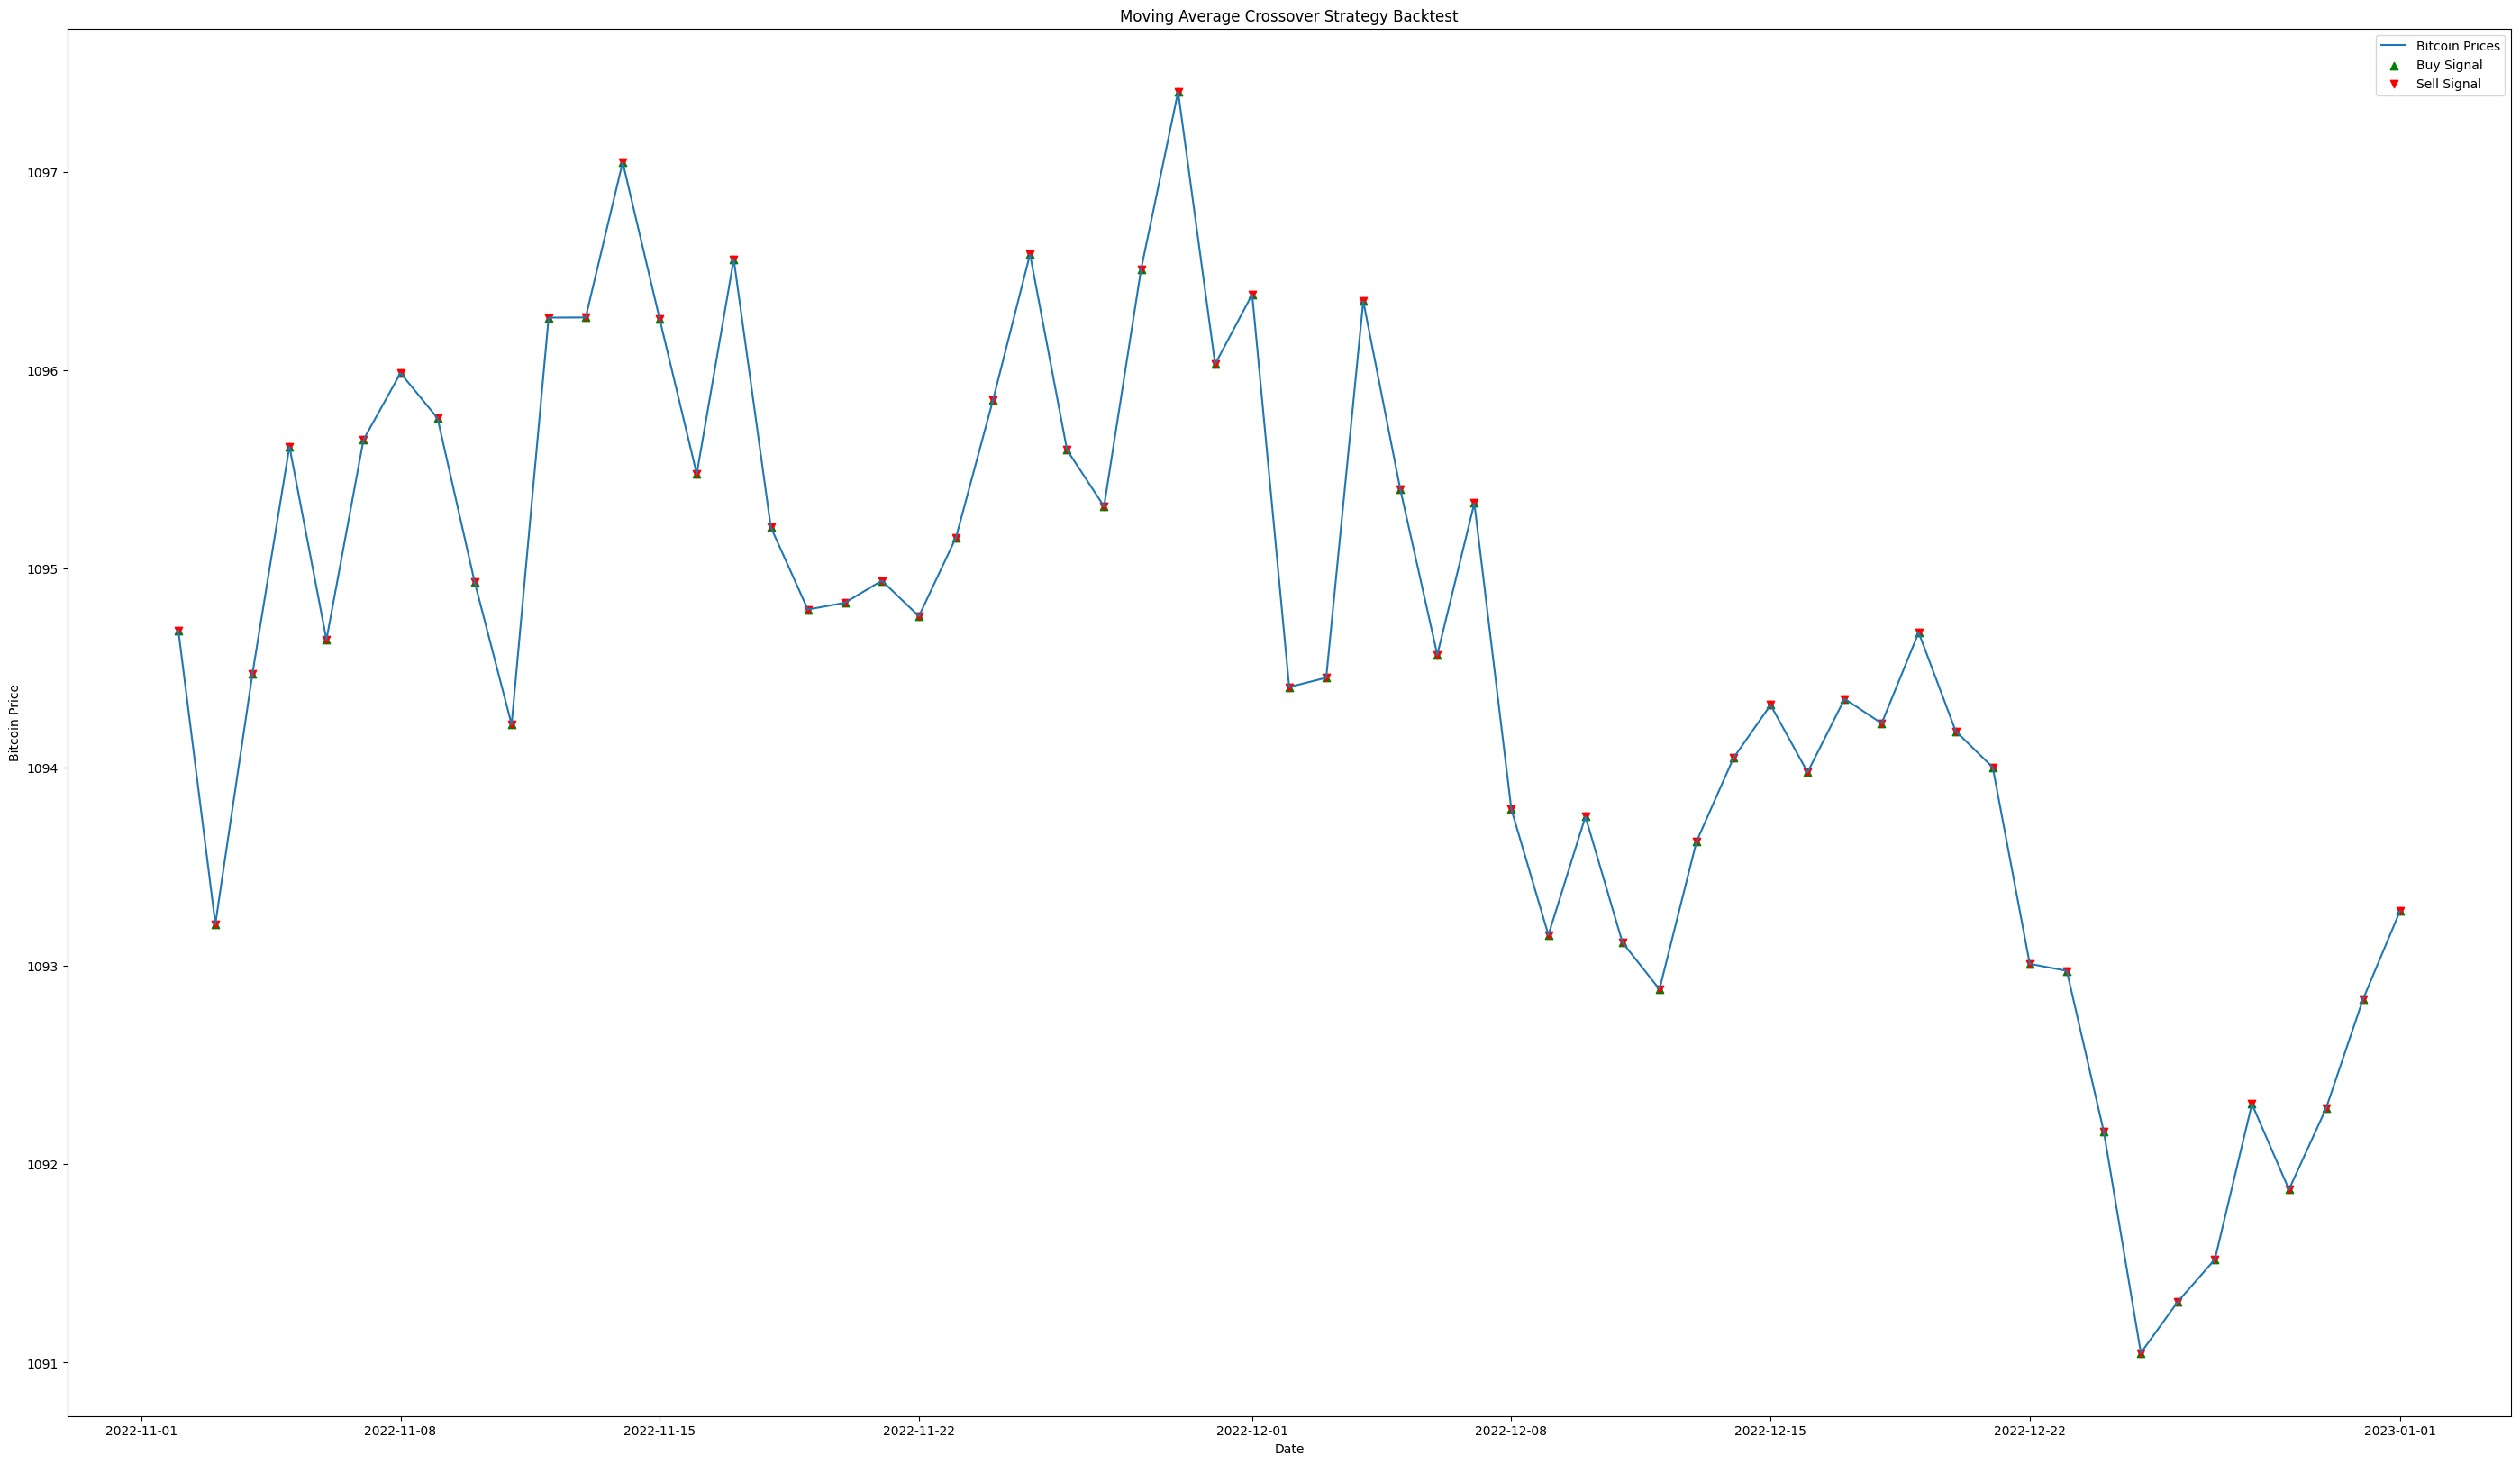

In [18]:
# Plotting for 3 months
plt.figure(figsize=(35, 20))
plt.plot(cdt.index, cdt['Price'], label='Bitcoin Prices')
plt.scatter(cdt.index[cdt['Signal'] == 1], cdt['Price'][cdt['Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(cdt.index[cdt['Signal'] == 1], cdt['Price'][cdt['Signal'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Moving Average Crossover Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

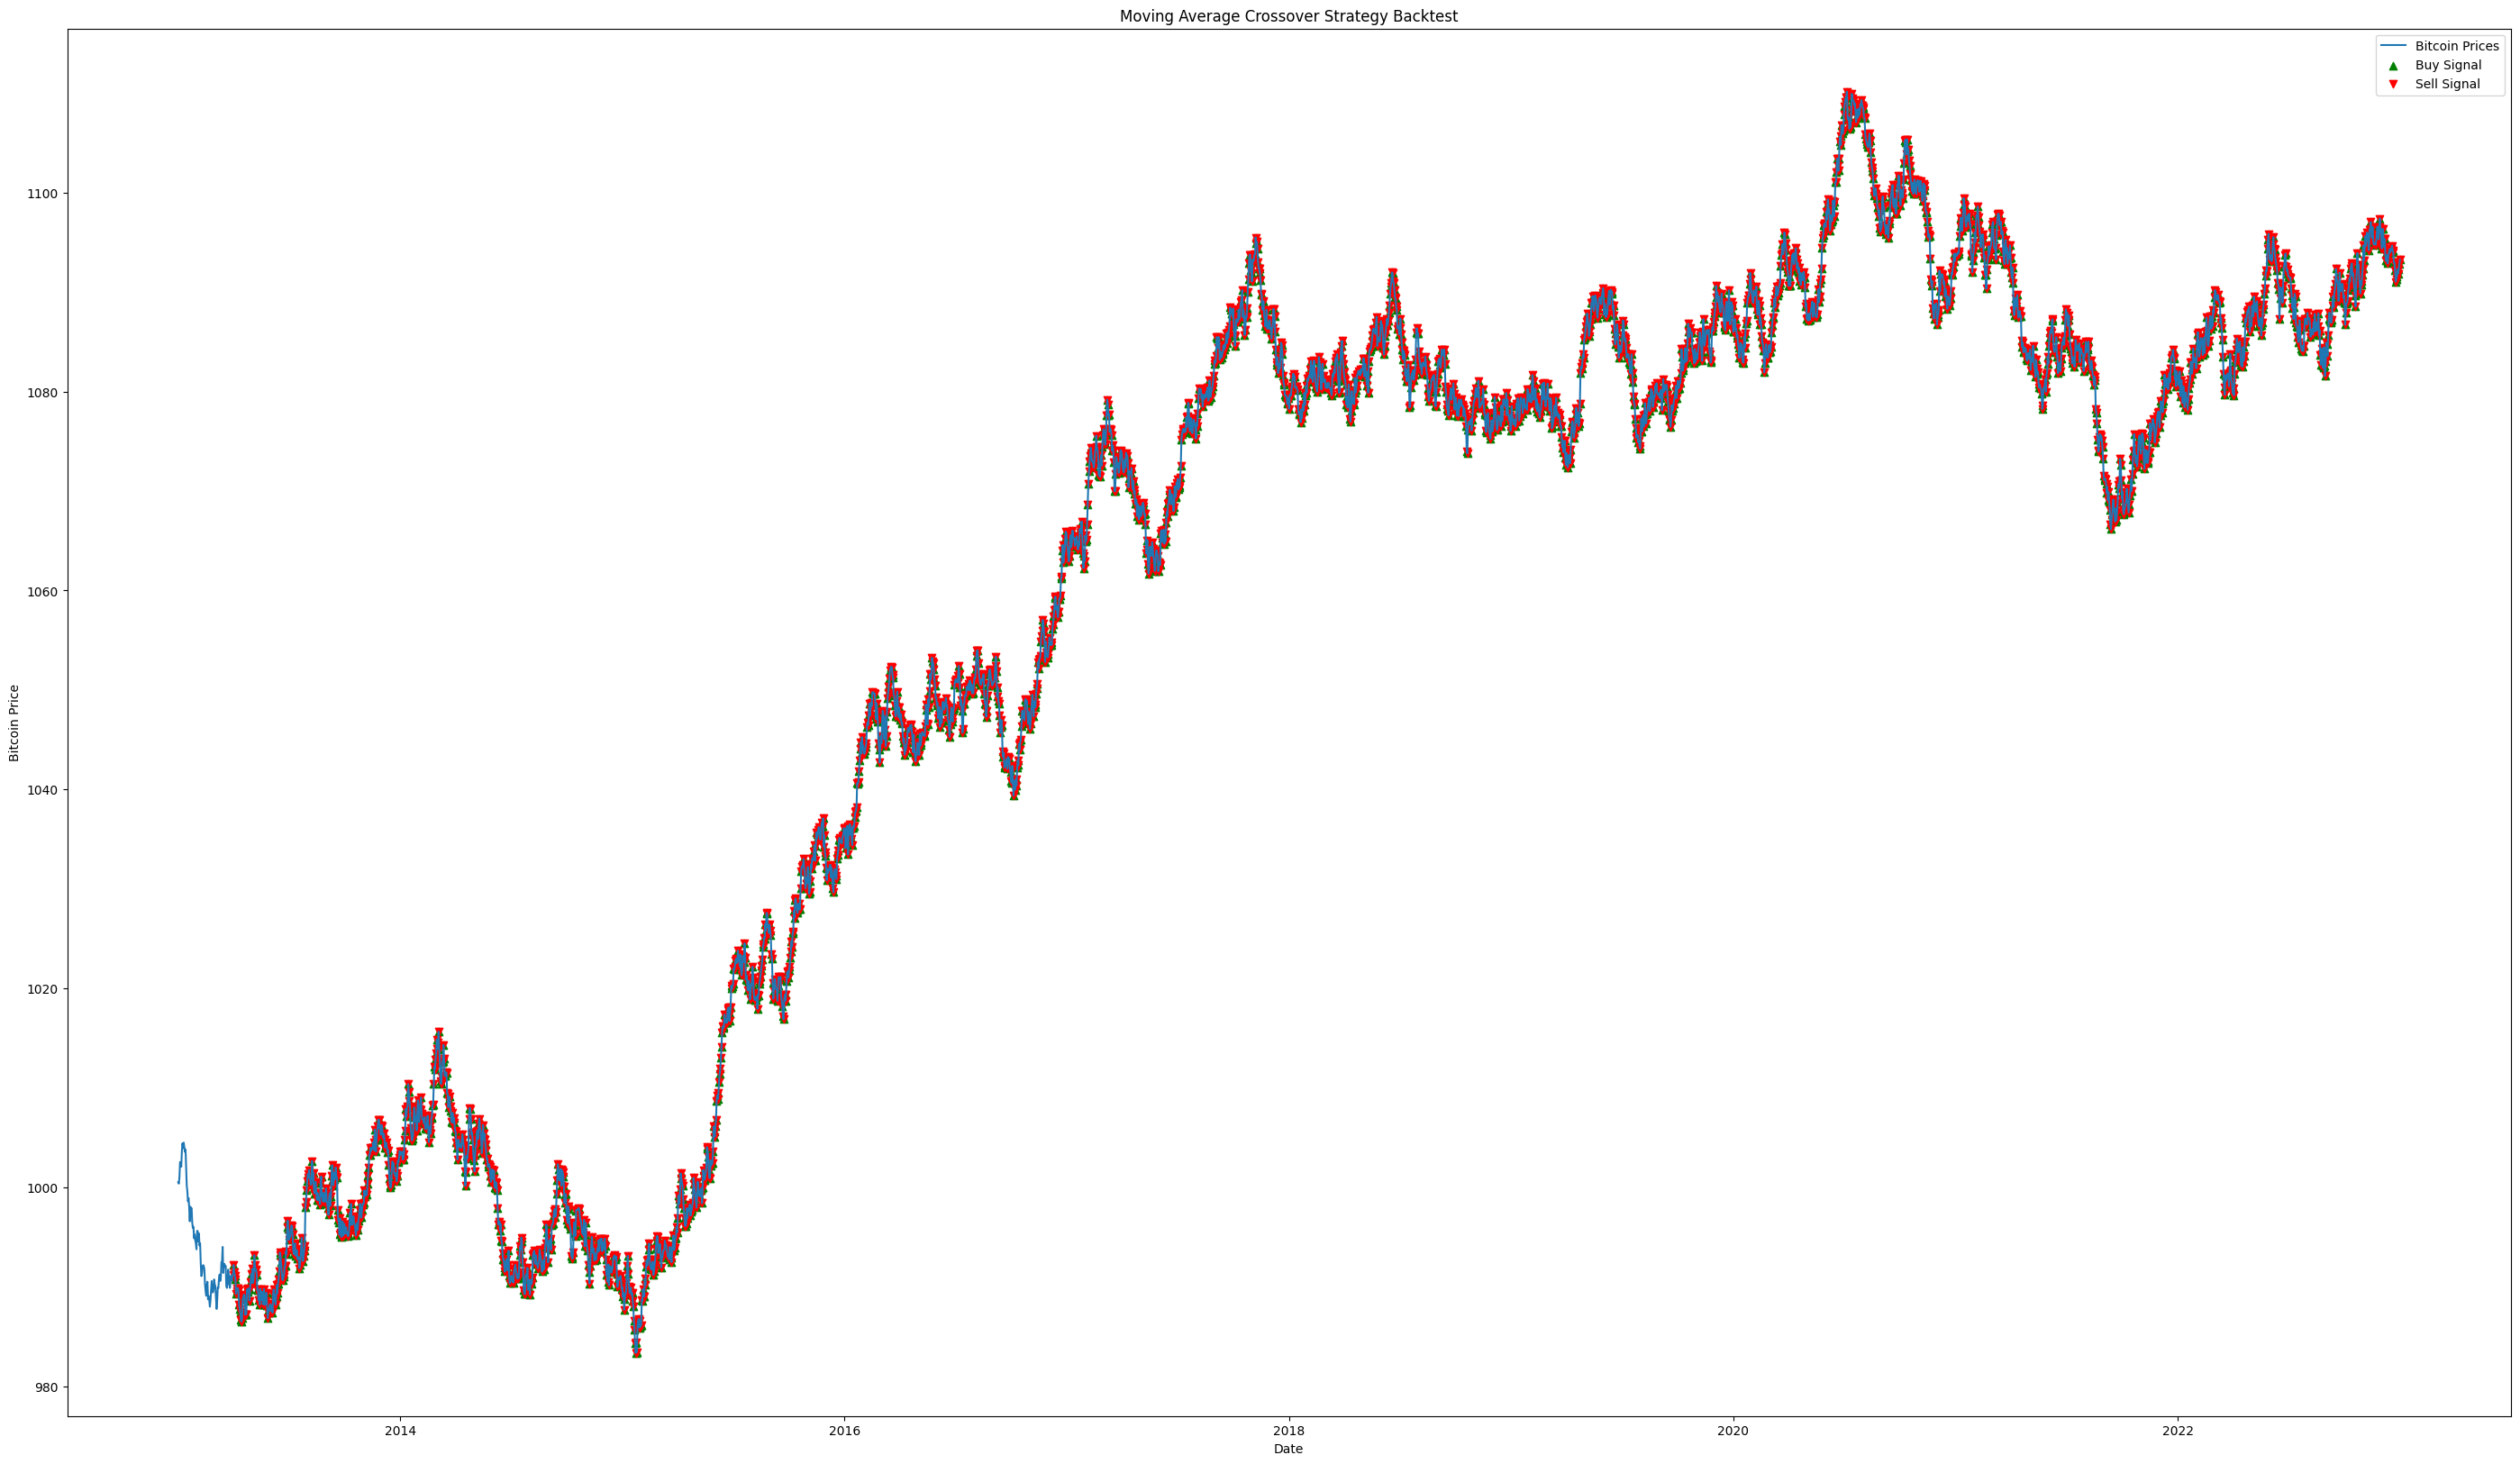

In [19]:
# Plotting for 10 years
plt.figure(figsize=(35, 20))
plt.plot(df.index, df['Price'], label='Bitcoin Prices')
plt.scatter(df.index[df['Signal'] == 1], df['Price'][df['Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(df.index[df['Signal'] == 1], df['Price'][df['Signal'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Moving Average Crossover Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


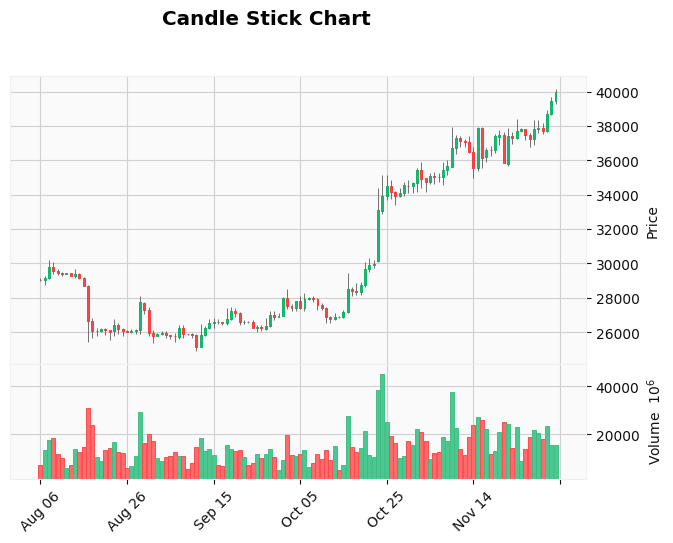

In [20]:
# Suppress the type error with try, except block
try: 
    # Candle Stick Chart
    fig,axes = mpf.plot(ohlc_btc.tail(120), type = "candle", style = "yahoo", title = "Candle Stick Chart", ylabel = "Price", volume = True)
   # Show results
    mpf.show()
except:
    pass


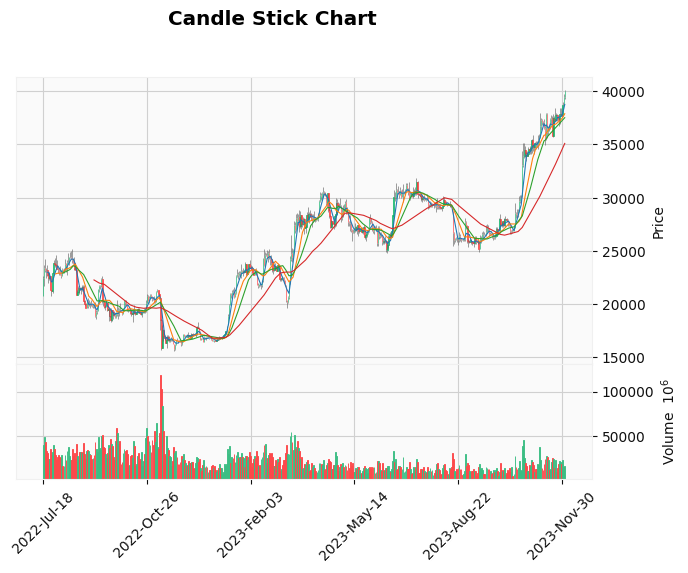

In [21]:
# Suppress the type error with try, except block
try:
    # Candle Stick Chart with MA
    fig,axes = mpf.plot(ohlc_btc.tail(504), type = "candle", style = "yahoo", title = "Candle Stick Chart", ylabel = "Price", volume = True, mav = (5,13,20,50))
   # Show results
    mpf.show()
except:
    pass